In [1]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib notebook

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imanursar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imanursar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imanursar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


FastText (https://fasttext.cc/) which is another extremely useful module for word embedding and text classification. Fast Text has been developed by Facebook and has shown excellent results on many NLP problems, such as semantic similarity detection and text classification.

# FastText for Semantic Similarity 

FastText supports both Continuous Bag of Words and Skip-Gram models

## Scraping Wikipedia Articles

In [2]:
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
machine_learning = wikipedia.page("Machine Learning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

artificial_intelligence = sent_tokenize(artificial_intelligence)
machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

The scraped content from the four Wikipedia pages are then tokenized into sentences using the sent_tokenize method. The method returns list of sentences. The sentences for the four pages are tokenized separately. Finally,
sentences from the four articles are joined together via the extend method. 

## Data Preprocessing

### clean text data 

In [3]:
import re
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
def preprocess_text(document):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    # if your text string is in bytes format a character b is appended with the string.
    # The b prefix signifies a bytes string literal.
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [word for word in tokens if len(word) > 3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

You can see the punctuations and stop words have been removed, and the sentences have been lemmatized. Furthermore, words with length less than 4, such as "era", have also been removed. These choices were chosen randomly for this test, so you may allow the words with smaller or greater lengths in the corpus. 

In [4]:
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]

## Creating Words Representation 

create word representations using FastText. first define the hyper-parameters for our FastText model: 

In [5]:
embedding_size = 60
window_size = 40
min_word = 5
down_sampling = 1e-2

Here embedding_size is the size of the embedding vector. In other words, each word in our corpus will be represented as a 60-dimensional vector. 

The window_size is the size of the number of words occurring before and after the word based on which the word representations will be learned for the word. This might sound tricky, however in the skip-gram model we input a word to the algorithm and the output is the context words.
If the window size is 40, for each input there will be 80 outputs: 40 words that occur before the input word and 40 words that occur after the input word. 

The word embeddings for the input word are learned using these 80 output words. 

min_word, which specifies the minimum frequency of down_sampling a word in the corpus for which the word representations will be generated. 

Finally, the most frequently occurring word will be down-sampled by a number specified by the attribute. 

## create FastText model for word representations. 

In [14]:
%%time
ft_model = FastText(word_tokenized_corpus,
                    size=embedding_size,
                    window=window_size,
                    min_count=min_word,
                    sample=down_sampling,
                    sg=1,
                    iter=100)

Wall time: 21.4 s


The sg parameter defines the type of model that we want to create. 
A value of 1 specifies that we want to create skip-gram model. 
Whereas zero specifies the bag of words model, which is the default value as well. 

Let's now see the word representation for the word "artificial". To do so, you can use the wv method of the FastText object and pass it the name of the word inside a list. 

In [15]:
print(ft_model.wv['artificial'])

[-0.7236482   0.03095572  0.02042324  0.21447054 -0.26373333 -0.09839499
 -0.03288196  0.36906317 -0.0362101  -0.26398036  0.06024726  0.516034
 -0.05690056 -0.23510337 -0.07330659  0.32498527 -0.0866221   0.11334378
 -0.3803075   0.19432224  0.337736    0.26767048  0.20710012 -0.18780847
 -0.22184087 -0.48028505 -0.00561448  0.42843774 -0.15155862  0.2614921
 -0.6670166   0.24131998 -0.09467148 -0.14956445 -0.08540054  0.09063317
  0.30763292 -0.26646435 -0.1090943   0.13123943 -0.3345135  -0.16202496
  0.0780476   0.08385874 -0.30055913 -0.7058292  -0.12232309 -0.21663399
 -0.3515622   0.41542193 -0.27125877 -0.25463456  0.4599721  -0.3704425
 -0.16380136  0.3097225   0.41054982 -0.0429067  -0.27146575 -0.51678365]


Let's now find top 5 most similar words for the words 'artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep'. You can chose any number of words. The following script prints the specified words along with the 5 most similar words from a list of 6 words. 

In [16]:
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn =5)]
                              for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent','deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'inspired', 'moral', 'technology', 'question']
intelligence:['artificial', 'intelligent', 'moral', 'think', 'simulate']
machine:['learning', 'ethic', 'concerned', 'computer', 'limit']
network:['neural', 'deep', 'connectionist', 'convolutional', 'layer']
recurrent:['shown', 'sequential', 'network', 'rnns', 'convolutional']
deep:['neural', 'network', 'learning', 'speech', 'generative']


the cosine similarity between the vectors for any two words, The value can be anywhere between O and 1. 
A higher value means higher similarity. 

In [17]:
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))

0.8124373


## Visualizing Word Similarities 

Though each word in our model is represented as 60-dimensional vector, we can use principal component analysis technique to find two principal components. The two principal components can then be used to plot the words in a two dimensional space.

In [18]:
from sklearn.decomposition import PCA
all_similar_words = sum([[k] + v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)
print(type(all_similar_words))
print(len(all_similar_words))

['artificial', 'intelligence', 'inspired', 'moral', 'technology', 'question', 'intelligence', 'artificial', 'intelligent', 'moral', 'think', 'simulate', 'machine', 'learning', 'ethic', 'concerned', 'computer', 'limit', 'network', 'neural', 'deep', 'connectionist', 'convolutional', 'layer', 'recurrent', 'shown', 'sequential', 'network', 'rnns', 'convolutional', 'deep', 'neural', 'network', 'learning', 'speech', 'generative']
<class 'list'>
36


we have to find the word vectors for all these 30 words, and then use PCA to reduce the dimensions of the word vectors from 60 to 2. 

<IPython.core.display.Javascript object>


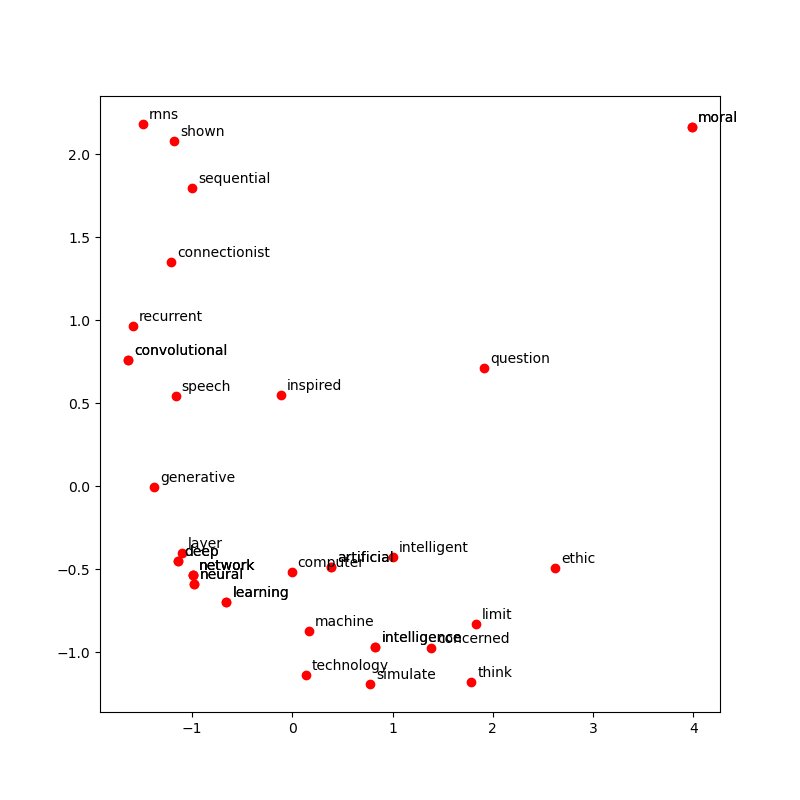

In [19]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)
p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(8, 8))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')
    
plt.show()

You can see the words that frequently occur together in the text are close to each other in the two dimensional plane as well.